# Case-Study-Hydrographic-Survey-Data-Correction-Analysis
This .ipynb is for **2511-ML Eng. Intern** task - _Case Study: Hydrographic Survey Data Correction & Analysis_. Please run the code blocks step-by-step.

## Step 1: Import Libraries and Customized Functions

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from headers import process_file_add_header
from diagnose_heading import diagnose_heading_from_vcog
from reconstruct_cable import process_vcog_to_corrected_ccog

## Step 2: Process the Raw Data and Add Headers
In this step, the column meaninngs were inferred based on the data format and the description of project. For example, according to the project description and the working principle of cable tracking, a VCOG file should contain the three-dimensional Vehicle Center of Gravity data, offset values, heading, and other related fields. Additionally, the numerical ranges and units in the data allow us to deduce the specific meaning of each column. Therefore, a pre-defined header was provided for different files (VCOG or CCOG).

**vcog_raw** and **ccog_raw** represent the paths to the raw **VCOG** or **CCOG** files, **which should be modified based on the user's path**.

The new files with headers will be named with suffix __identified_.

In [28]:
vcog_raw = r"D:\Intern\2511-ml-case-study\Exp_1_VCoG_TOC.csv"
ccog_raw = r"D:\Intern\2511-ml-case-study\Exp_1_CCoG_TOC.csv"

vcog_identified = process_file_add_header(str(vcog_raw))
ccog_identified = process_file_add_header(str(ccog_raw))

vcog_identified, ccog_identified

(WindowsPath('D:/Intern/2511-ml-case-study/Exp_1_VCoG_TOC_identified.csv'),
 WindowsPath('D:/Intern/2511-ml-case-study/Exp_1_CCoG_TOC_identified.csv'))

## Step 3: Diagnose and Visualize Heading Issue
In this step, the mean heading error is calculated accoriding to GPS-reported heading and track-derived heading. The heading error distribution is also visualized for more insights of GPS orientation issue.

Mean heading error: 2.03°


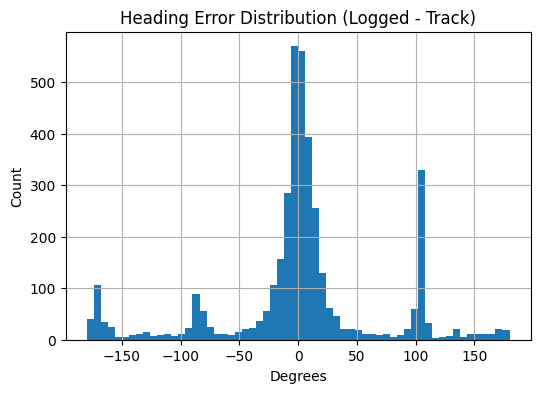

In [29]:
errors = diagnose_heading_from_vcog(str(vcog_identified))

## Step 4: Reconstruct of Ture Cable Path
According to the documentation, the intended +90° correction was mistakenly applied as –90°. Therefore, a +180° adjustment was applied to the heading values in the VCOG file, and the cable’s true position was recomputed from the corrected heading and the EM offsets. The VCOG file with corrected position is named with __corrected_.

In [30]:
ccog_corrected = process_vcog_to_corrected_ccog(str(vcog_identified))
ccog_corrected

[reconstruct] Wrote corrected file: D:\Intern\2511-ml-case-study\Exp_1_CCoG_TOC_identified_corrected.csv


WindowsPath('D:/Intern/2511-ml-case-study/Exp_1_CCoG_TOC_identified_corrected.csv')

Visualizing the path via the following code.

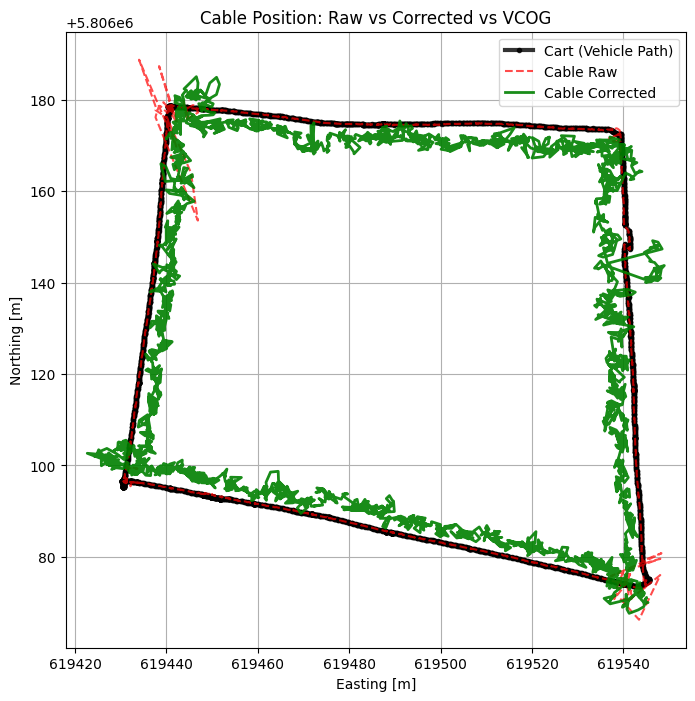

In [31]:
df_v = pd.read_csv(vcog_identified)
df_c_raw = pd.read_csv(ccog_identified)
df_c_cor = pd.read_csv(ccog_corrected)

plt.figure(figsize=(8, 8))

plt.plot(
    df_v["vehicle_easting_m"],
    df_v["vehicle_northing_m"],
    label="Cart (Vehicle Path)",
    color="black",
    linewidth=3,
    marker="o",
    markersize=3,
    alpha=0.8,
)

plt.plot(
    df_c_raw["cable_easting_m"],
    df_c_raw["cable_northing_m"],
    label="Cable Raw",
    color="red",
    linestyle="--",
    alpha=0.7,
)

plt.plot(
    df_c_cor["cable_easting_m"],
    df_c_cor["cable_northing_m"],
    label="Cable Corrected",
    color="green",
    linewidth=2,
    alpha=0.9,
)

plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.title("Cable Position: Raw vs Corrected vs VCOG")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

## Step 5: Results Analysis and Visualization
In this step, several statistic analysis are performed to further evaluate the performance of the algorithm.

### Mean Difference
The mean difference between the raw and corrected cable positions is used to quantify the impact of the heading issue on the reconstructed path.

Mean difference between raw and corrected cable position : 6.323 m


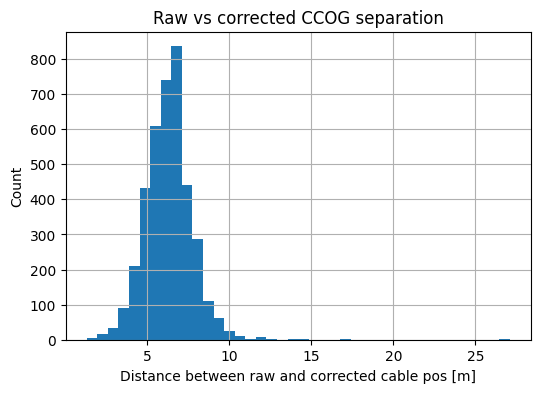

In [32]:
merged = pd.merge_asof(
    df_c_raw.sort_values("time_s"),
    df_c_cor.sort_values("time_s"),
    on="time_s",
    suffixes=("_raw", "_corr")
)

dE_raw_corr = merged["cable_easting_m_corr"] - merged["cable_easting_m_raw"]
dN_raw_corr = merged["cable_northing_m_corr"] - merged["cable_northing_m_raw"]
dist = (dE_raw_corr**2 + dN_raw_corr**2) ** 0.5

print(f"Mean difference between raw and corrected cable position : {dist.mean():.3f} m")

plt.figure(figsize=(6, 4))
plt.hist(dist, bins=40)
plt.xlabel("Distance between raw and corrected cable pos [m]")
plt.ylabel("Count")
plt.title("Raw vs corrected CCOG separation")
plt.grid(True)
plt.show()

### Error Vector Field
The error vector field provides a spatial visualization of how the cable reconstruction deviates between the raw and corrected results. Each vector represents both the magnitude and direction of the positional error at a given point along the trajectory. This allows the observation of systematic directional biases introduced by the heading issue and how they are resolved after applying the correction.

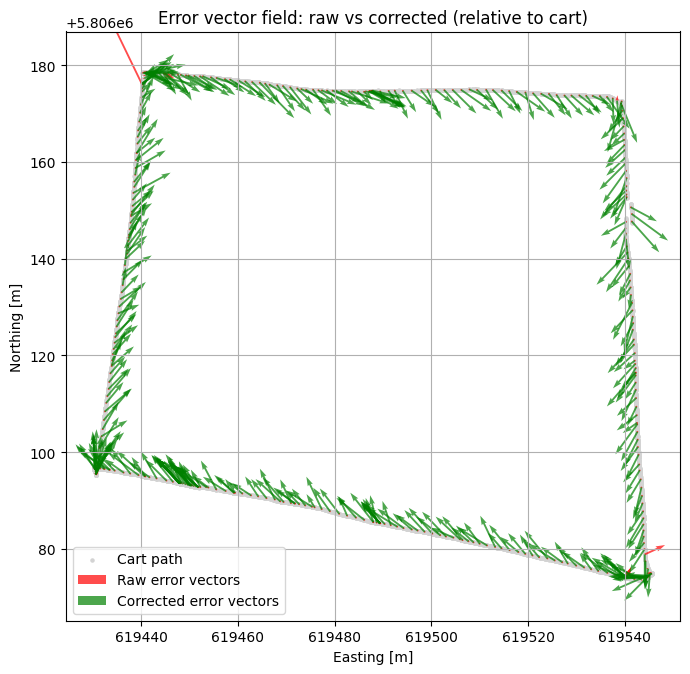

In [33]:
merged_raw = pd.merge_asof(
    df_v.sort_values("time_s"),
    df_c_raw.sort_values("time_s"),
    on="time_s",
    suffixes=("_v", "_raw")
)

# --- merge cart + corrected cable ---
merged_cor = pd.merge_asof(
    df_v.sort_values("time_s"),
    df_c_cor.sort_values("time_s"),
    on="time_s",
    suffixes=("_v", "_cor")
)

# =========================
# 1) Error vector field
# =========================
step = 10

Ex = merged_raw["vehicle_easting_m"]
Ny = merged_raw["vehicle_northing_m"]

# raw error vectors (relative to cart)
u_raw = merged_raw["cable_easting_m"] - merged_raw["vehicle_easting_m"]
v_raw = merged_raw["cable_northing_m"] - merged_raw["vehicle_northing_m"]

# corrected error vectors (relative to cart)
u_cor = merged_cor["cable_easting_m"] - merged_cor["vehicle_easting_m"]
v_cor = merged_cor["cable_northing_m"] - merged_cor["vehicle_northing_m"]

idx = np.arange(0, len(merged_raw), step)

plt.figure(figsize=(7,7))
plt.scatter(Ex, Ny, s=5, color="lightgray", label="Cart path")

plt.quiver(
    Ex.iloc[idx],
    Ny.iloc[idx],
    u_raw.iloc[idx],
    v_raw.iloc[idx],
    color="red",
    alpha=0.7,
    label="Raw error vectors",
    angles="xy",
    scale_units="xy",
    scale=1.0,
)

plt.quiver(
    Ex.iloc[idx],
    Ny.iloc[idx],
    u_cor.iloc[idx],
    v_cor.iloc[idx],
    color="green",
    alpha=0.7,
    label="Corrected error vectors",
    angles="xy",
    scale_units="xy",
    scale=1.0,
)

plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.title("Error vector field: raw vs corrected (relative to cart)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

### Error Heatmap
The error heatmap illustrates how the positional error between the raw and corrected cable paths varies across space. By mapping error magnitude to color intensity, the heatmap highlights regions where the heading issue caused larger deviations and areas where the reconstruction remained relatively stable.

In [39]:
E_c = merged_cor["cable_easting_m"].values
N_c = merged_cor["cable_northing_m"].values
error_dist = dist_cor  

bins = 60

heatmap, xedges, yedges = np.histogram2d(E_c, N_c, bins=bins, weights=error_dist)
counts, _, _ = np.histogram2d(E_c, N_c, bins=bins)

avg_error = heatmap / np.maximum(counts, 1)

plt.figure(figsize=(8,7))
plt.imshow(avg_error.T, origin='lower', cmap='hot',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

plt.colorbar(label="Mean Error [m]")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.title("Error Heatmap (Corrected CCOG)")
plt.grid(False)
plt.show()

NameError: name 'dist_cor' is not defined

### Offset-to-Error Mapping
The offset-to-error mapping examines how the positional error varies as a function of the EM offset magnitude. By plotting the world-coordinate reconstruction error against the lateral offset distance, this analysis reveals how sensor performance changes with increasing separation from the cable. A near-linear trend indicates that larger offsets produce proportionally larger reconstruction errors, consistent with expected EM signal attenuation.

In [35]:
dx = df_v["cable_offset_x_m"].values
dy = df_v["cable_offset_y_m"].values
offset_mag = np.sqrt(dx**2 + dy**2)

plt.figure(figsize=(6,5))
plt.scatter(offset_mag[:len(dist_cor)], dist_cor, alpha=0.4)
plt.xlabel("Offset magnitude sqrt(dx^2 + dy^2) [m]")
plt.ylabel("Corrected cable error [m]")
plt.title("Offset Magnitude vs Corrected Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(dx[:len(dist_cor)], dist_cor, alpha=0.4)
plt.xlabel("dx [m]")
plt.ylabel("Corrected cable error [m]")
plt.title("Offset dx vs Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(dy[:len(dist_cor)], dist_cor, alpha=0.4)
plt.xlabel("dy [m]")
plt.ylabel("Corrected cable error [m]")
plt.title("Offset dy vs Error")
plt.grid(True)
plt.show()

NameError: name 'dist_cor' is not defined

<Figure size 600x500 with 0 Axes>